# Hotel Recommendation System using Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#necessary for GPU users
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
url = 'https://raw.githubusercontent.com/zulfauzi92/Hotel_Recomendation_Model_Traveloka/main/Eksplorasi%20Data/Main%20Dataset/csv_final/Final_Dataset_User_ML.csv'
hotel_train_data = pd.read_csv(url)

In [4]:
hotel_train_data.head(2)

,Unnamed: 0,user_id,most_reviewed,reviewed_hotel,latitude,longitude,hotel_star_rating,site_review_rating,Beach Hut,BnB,...,Heating Facility on Request,Safe,Iron / Ironing board,Microwave / Oven,Window Open / Ventilation,Outdoor Parking,Porter Services,Spa Services,Poolside Cafe,Airport Transfer
0,0,U000001,H000021,['H000021'],34.4,-119.8,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,U000002,H001054,['H001054'],36.6,-121.9,3.0,2.5,0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# Data Pre-processing

In [11]:
df = hotel_train_data[['user_id','reviewed_hotel','site_review_rating','latitude','longitude']]

In [12]:
#For collaborative, we'll use ratings & location
#df.columns =['user_id', 'most_reviewed', 'site_review_rating', 'latitude', 'longitude']
df.head()

,user_id,reviewed_hotel,site_review_rating,latitude,longitude
0,U000001,['H000021'],1.0,34.4,-119.8
1,U000002,['H001054'],2.5,36.6,-121.9
2,U000003,['H001054'],2.5,36.6,-121.9
3,U000004,['H001054'],2.5,36.6,-121.9
4,U000005,['H001054'],2.5,36.6,-121.9


In [13]:
df.shape

(9219, 5)

In [14]:
n_users = len(df.user_id.unique())
n_users

9219

In [16]:
n_hotels = len(df.reviewed_hotel.unique())
n_hotels

1657

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9219 entries, 0 to 9218
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             9219 non-null   object 
 1   reviewed_hotel      9219 non-null   object 
 2   site_review_rating  9219 non-null   float64
 3   latitude            9219 non-null   float64
 4   longitude           9219 non-null   float64
dtypes: float64(3), object(2)
memory usage: 360.2+ KB


Create variables with the total number of unique users and item in the data, as well as the min and max ratings present in the data

In [20]:
from ast import literal_eval

df['reviewed_hotel'] = df['reviewed_hotel'].apply(lambda x: int(np.array(literal_eval(x))[0][1:]))
df['reviewed_hotel']

0         21
1       1054
2       1054
3       1054
4       1054
        ... 
9214    1298
9215    1298
9216    1298
9217    1103
9218    1154
Name: reviewed_hotel, Length: 9219, dtype: int64

In [23]:
user_enc = LabelEncoder()
df['user_id'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user_id'].nunique()

n_items = df['reviewed_hotel'].nunique()

df['site_review_rating'] = df['site_review_rating'].values.astype(np.float32)
min_rating = min(df['site_review_rating'])
max_rating = max(df['site_review_rating'])

df['latitude'] = df['latitude'].values.astype(np.float32)
df['longitude'] = df['longitude'].values.astype(np.float32)
n_users, n_items
print(min_rating, max_rating)

1.0 5.0


In [24]:
df.head()

,user_id,reviewed_hotel,site_review_rating,latitude,longitude
0,0,21,1.0,34.400002,-119.800003
1,1,1054,2.5,36.599998,-121.900002
2,2,1054,2.5,36.599998,-121.900002
3,3,1054,2.5,36.599998,-121.900002
4,4,1054,2.5,36.599998,-121.900002


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9219 entries, 0 to 9218
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             9219 non-null   int64  
 1   reviewed_hotel      9219 non-null   int64  
 2   site_review_rating  9219 non-null   float32
 3   latitude            9219 non-null   float32
 4   longitude           9219 non-null   float32
dtypes: float32(3), int64(2)
memory usage: 252.2 KB


# Split the data into training and test data sets

In [26]:
X = df[['user_id', 'reviewed_hotel']].values
y = df[['site_review_rating', 'latitude', 'longitude']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7375, 2), (1844, 2), (7375, 3), (1844, 3))

In [27]:
print(df['user_id'])

0          0
1          1
2          2
3          3
4          4
        ... 
9214    9214
9215    9215
9216    9216
9217    9217
9218    9218
Name: user_id, Length: 9219, dtype: int64


In [29]:
print(df['reviewed_hotel'])

0         21
1       1054
2       1054
3       1054
4       1054
        ... 
9214    1298
9215    1298
9216    1298
9217    1103
9218    1154
Name: reviewed_hotel, Length: 9219, dtype: int64


In [30]:
n_factors = 240
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Creating Neural Network

Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

Embeddings are weights that are learned to represent some specific variable like items and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [67]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
    
# add fully-connected-layers
fc1 = Dense(256, activation='relu')(x)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = tf.keras.layers.Dropout(0.5)(fc2)
fc4 = tf.keras.layers.Dropout(0.3)(fc3)
fc5 = tf.keras.layers.Dropout(0.1)(fc4)
out = Dense(1)(fc5)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer = opt, loss = 'mean_absolute_error', metrics=['accuracy'])

In [68]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 1, 240)       2212560     ['input_19[0][0]']               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 240)       306240      ['input_20[0][0]']               
                                                                                            

In [69]:
history = model.fit(x=X_train_array, y=y_train, batch_size=32, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
231/231 [==============================] - 3s 8ms/step - loss: 46.6881 - accuracy: 0.0055 - val_loss: 46.4649 - val_accuracy: 0.0110
Epoch 2/20
231/231 [==============================] - 2s 7ms/step - loss: 46.0101 - accuracy: 0.0107 - val_loss: 45.9436 - val_accuracy: 0.0110
Epoch 3/20
231/231 [==============================] - 2s 7ms/step - loss: 45.8627 - accuracy: 0.0107 - val_loss: 45.8641 - val_accuracy: 0.0110
Epoch 4/20
231/231 [==============================] - 2s 7ms/step - loss: 45.8268 - accuracy: 0.0107 - val_loss: 45.8370 - val_accuracy: 0.0110
Epoch 5/20
231/231 [==============================] - 2s 7ms/step - loss: 45.8102 - accuracy: 0.0107 - val_loss: 45.8335 - val_accuracy: 0.0110
Epoch 6/20
231/231 [==============================] - 2s 7ms/step - loss: 45.8013 - accuracy: 0.0107 - val_loss: 45.8222 - val_accuracy: 0.0110
Epoch 7/20
231/231 [==============================] - 2s 7ms/step - loss: 45.7974 - accuracy: 0.0107 - val_loss: 45.8172 - val_accuracy:

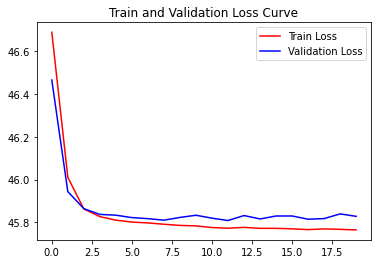

In [70]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [71]:
#Evaluate the model
score = model.evaluate(X_test_array, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 45.82806396484375
Test accuracy: 0.011026754043996334


In [ ]:
model.save('collaborative_model_user.h5')

## Creating RMSE function for Neural Network

In [20]:
def root_mean_squared_error(y_test, y_train):
        return K.sqrt(K.mean(K.square(y_test - y_train))) 

In [25]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
     
# add fully-connected-layers
fc1 = Dense(256, activation='relu')(x)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = tf.keras.layers.Dropout(0.1)(fc2)
out = Dense(1)(fc3)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer = opt , loss = root_mean_squared_error, metrics=['accuracy'])

NameError: name 'root_mean_squared_error' is not defined

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 240)       2212560     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 240)       397680      ['input_4[0][0]']                
                                                                                            

In [23]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
116/116 [==============================] - 13s 98ms/step - loss: 4.1236 - accuracy: 0.0000e+00 - val_loss: 4.1165 - val_accuracy: 0.0000e+00
Epoch 2/20
116/116 [==============================] - 11s 97ms/step - loss: 4.0922 - accuracy: 0.0000e+00 - val_loss: 4.0861 - val_accuracy: 0.0000e+00
Epoch 3/20
116/116 [==============================] - 11s 98ms/step - loss: 4.0608 - accuracy: 0.0000e+00 - val_loss: 4.0555 - val_accuracy: 0.0000e+00
Epoch 4/20
116/116 [==============================] - 12s 100ms/step - loss: 4.0291 - accuracy: 0.0000e+00 - val_loss: 4.0243 - val_accuracy: 0.0000e+00
Epoch 5/20
116/116 [==============================] - 12s 102ms/step - loss: 3.9961 - accuracy: 0.0000e+00 - val_loss: 3.9924 - val_accuracy: 0.0000e+00
Epoch 6/20
116/116 [==============================] - 12s 99ms/step - loss: 3.9630 - accuracy: 0.0000e+00 - val_loss: 3.9595 - val_accuracy: 0.0000e+00
Epoch 7/20
116/116 [==============================] - 12s 101ms/step - loss: 3.9282 - 

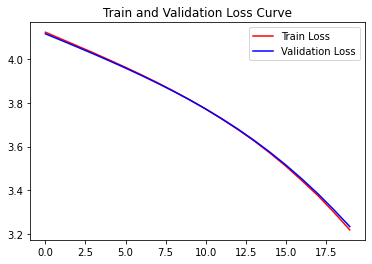

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [1]:
#Evaluate the model
score = model.evaluate(X_test_array, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'model' is not defined

# Making Recommendations

In [74]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(df.Item_id)))
hotel_data[:5]

array([0, 1, 2, 3, 4])

In [75]:
user = np.array([1 for i in range(len(hotel_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [76]:
predictions = model.predict([user, hotel_data])

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()[:5]

recommended_item_ids

array([72, 49, 59, 19, 36], dtype=int64)

In [77]:
# print predicted scores
predictions[recommended_item_ids]

array([0.19043083, 0.18687372, 0.18581037, 0.18546915, 0.18278559],
      dtype=float32)

# Recommend Hotel Cluster for a User

In [99]:
rows = []
hotel = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)
names = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'Item_id' : hotel[i], 'User_id' : 1048}))
test_data = pd.DataFrame(rows)

In [100]:
for idx, (score, name) in enumerate(sorted(zip(recommended_item_ids, names), reverse=True)):
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  72.0  for hotel cluster:  1
Score:  59.0  for hotel cluster:  21
Score:  49.0  for hotel cluster:  80
Score:  36.0  for hotel cluster:  41
Score:  19.0  for hotel cluster:  92


In [41]:
hotel_data = np.array(list(set(df['item'])))
hotel_data[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
id_user = 20
user = np.array([id_user for i in range (len(hotel_data))])
user[:10]

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [43]:
predictions = model.predict([user, hotel_data])
predictions = np.array([a[0] for a in predictions])
recommended_hotel_id = (-predictions).argsort()[:10]
recommended_hotel_id

45/45 [==============================] - 0s 5ms/step


array([  6,  83, 138,  21,  84,   4,  62, 115,  77,  34])

In [44]:
predictions[recommended_hotel_id]

array([4.595995 , 4.157644 , 3.9491413, 3.9372382, 3.914852 , 3.8839493,
       3.7683673, 3.7665148, 3.7572596, 3.6514044], dtype=float32)